# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import sys
import time

import arviz as az
import jax
from jax import numpy as jnp
from jax.random import PRNGKey
import numpy as np
import pandas as pd
import pymc as pm
from optax import adam
import tensorflow_probability.substrates.jax.distributions as tfd
from tensorflow_probability.substrates.jax.math import fill_triangular
from tqdm import tqdm


sys.path.append(os.path.abspath(".."))
from scripts.notebook_utils import (
    plot_elbo, 
    plot_true_predicted_comparison, 
    plot_regression_results, 
    plot_synthetic_data,
    plot_data,
    REGRESSION_COLORPALETTE,
    TRUEPARAM_COLORPALETTE,
    PREDPARAM_COLORPALETTE,
    ELBO_COLOR,
    EXCESS_COLOR,
)
from scripts.vigamlss import (
    Normal, 
    DataPreparator, 
    DegenerateNormal, 
    FullCovarianceNormal, 
    HalfCauchy, 
    TransformationFunctions,
    GPD,
    ALD,
    CenteredGPD,
)

os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

2025-02-12 20:14:57.184964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739387697.202400  321925 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739387697.210391  321925 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Save Dirs

In [2]:
pickle_dir_gpd = sys.path[-1] + "/results/gpd"
pickle_dir_gpd_sim = sys.path[-1] + "/results/sim/gpd"
pickle_dir_ald = sys.path[-1] + "/results/ald"
plot_dir = sys.path[-1] + "/plots/gpd"
plot_dir_gpd_sim = sys.path[-1] + "/plots/sim/gpd"
plot_dir_ald = sys.path[-1] + "/plots/ald"

# VIGAMLSS with GEV Response and PSplines

## Synthetic Data

### Preperations

#### Synthetic Data Creation

In [3]:
def vigamlss_gpd_create_syn_data(n_samples, seed, enable_plot=True):
    # ------------------------------------------------
    # 1) Generate covariate X
    # ------------------------------------------------
    key = PRNGKey(42)
    n_samples = n_samples
    key_x, key_y = jax.random.split(seed)
    X_SYN = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)
    X_SYN   = jnp.sort(X_SYN)
    # ------------------------------------------------
    # 2) Define parametric functions for loc(x), scale(x), shape(x)
    # ------------------------------------------------
    def loc_fn(x):
        return 0.1 * x**3
    def scale_fn(x):
        return 0.1 * x**2 + 0.5
    def shape_fn(x):
        return 0.1 * jnp.tanh(x) - 0.2
    loc_vals   = loc_fn(X_SYN)
    scale_vals = scale_fn(X_SYN)
    shape_vals = shape_fn(X_SYN)
    # ------------------------------------------------
    # 3) Constructs a *batch* of GPDs, one per (x_i).
    #    TFP automatically enforces domain logic for each sample.
    # ------------------------------------------------
    gpd_dists = tfd.GeneralizedPareto(
        loc          = loc_vals,     # shape=(n_samples,)
        scale        = scale_vals,   # shape=(n_samples,)
        concentration= shape_vals    # shape=(n_samples,)
    )
    # ------------------------------------------------
    # 4) Sample Y given X
    # ------------------------------------------------
    Y_SYN = gpd_dists.sample(seed=key_y)  # shape=(n_samples,)
    Y_SYN = jnp.array(Y_SYN)
    if enable_plot:
        plot_synthetic_data(
            X=X_SYN,
            Y=Y_SYN,
            scatterplot_color=REGRESSION_COLORPALETTE[0],
            line_palette=TRUEPARAM_COLORPALETTE,
            lines=[loc_vals, scale_vals, shape_vals],
            scatter_xlabel="X",
            scatter_ylabel="Y ~ GPD(loc(X), scale(X), shape(X))",
            scatter_title="Synthetic Data for Regression with GEV Response",
            line_xlabel="X",
            line_ylabel="Parameter Values",
            line_title="Parameter Variation with X",
            line_labels=["loc(X)","scale(X)","shape(X)"],
            file_name="gpd_syn_data_overview",
            save_dir=plot_dir,
        )

    return X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals

#### Data Preperation

In [4]:
def vigamlss_gpd_syn_data_prepare_data(X):
    DesignMatrix, K = DataPreparator(
        "DesignMatrix",
        X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
    )()
    return DesignMatrix, K

#### Model Definition

In [5]:
def vigamlss_gpd_syn_data_define_model(DesignMatrix, Y, K):
    β0_loc = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_loc = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
    γ_loc = DegenerateNormal("gammas_loc", K, λ_loc)

    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    β0_shape = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_shape = HalfCauchy("lambda_shape", jnp.array([0.1]), 1)
    γ_shape = DegenerateNormal("gammas_shape", K, λ_shape)

    Y = GPD(
        "y_GPD",
        β0_loc + DesignMatrix @ γ_loc,
        β0_scale + DesignMatrix @ γ_scale,
        β0_shape + DesignMatrix @ γ_shape,
        responses=Y,
    )
    return Y

#### Optimization Run

In [6]:
def vigamlss_gpd_syn_data_opt_run(Y, seed, print_time=True):
    start_time = time.time()
    results = Y.model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=50000,
        mb_size=None,
        lr=0.001,
        max_norm=1.0,
        clip_min_max_enabled=True,
        zero_nans_enabled=True,
        prng_key=seed,
        scheduler_type="constant",
    )
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    minutes, seconds = divmod(elapsed_seconds, 60)
    if print_time:
        print(f"Elapsed time for optimization: {int(minutes)} min: {seconds:.2f} sec")
    return results

#### Results Aggregation

In [7]:
def vigamlss_gpd_syn_data_results(results, DesignMatrix, X, Y, loc_vals, scale_vals, shape_vals):
    β0_loc_opt = results["transformed_loc_vi_parameters"]["beta0_loc"]
    γ_loc_opt = results["transformed_loc_vi_parameters"]["gammas_loc"]
    β0_scale_opt = results["transformed_loc_vi_parameters"]["beta0_scale"]
    γ_scale_opt = results["transformed_loc_vi_parameters"]["gammas_scale"]
    β0_shape_opt = results["transformed_loc_vi_parameters"]["beta0_shape"]
    γ_shape_opt = results["transformed_loc_vi_parameters"]["gammas_shape"]

    linear_predictor_loc = β0_loc_opt + DesignMatrix.matrix @ γ_loc_opt
    linear_predictor_scale = TransformationFunctions.softplus(β0_scale_opt + DesignMatrix.matrix @ γ_scale_opt)
    linear_predictor_shape = β0_shape_opt + DesignMatrix.matrix @ γ_shape_opt

    gpd_dists = tfd.GeneralizedPareto(
        linear_predictor_loc, 
        linear_predictor_scale, 
        linear_predictor_shape
    )
    samples = gpd_dists.sample((100000,), PRNGKey(0))
    samples = np.array(samples)

    pred_mean_line = gpd_dists.mean()
    pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)
    pred_hdi_lower = pred_hdi_bounds[:, 0]
    pred_hdi_upper = pred_hdi_bounds[:, 1]

    plot_elbo(
        num_iterations=results["svi_metadata"]["num_iterations"],
        elbo_values=results["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.1,
        final_percentage=0.8,
        save_dir=plot_dir,
        file_name="syn_data_elbo",
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        x_pred=X,
        pred_mean=pred_mean_line,
        lower_hdi_bound=pred_hdi_lower,
        upper_hdi_bound=pred_hdi_upper,
        hdi_alpha=0.2,
        regression_colorpalette=REGRESSION_COLORPALETTE,
        scatter_label="Data Points",
        regression_label="Regression Line",
        hdi_label="95% HDI",
        xlabel="X",
        ylabel="Response",
        title="Bayesian P-Spline Regression for GPD Response with 95% HDI",
        save_dir=plot_dir,
        file_name="syn_data_regression_results"
    )
    plot_true_predicted_comparison(
        X=X,
        true_parameter_values=[loc_vals, scale_vals, shape_vals],
        predicted_parameter_values=[
            linear_predictor_loc, 
            linear_predictor_scale, 
            linear_predictor_shape
        ],
        true_palette=TRUEPARAM_COLORPALETTE,
        pred_palette=PREDPARAM_COLORPALETTE,
        line_labels=["Location", "Scale", "Shape"],
        title="Comparison of True vs. Predicted GPD Parameters",
        xlabel="X",
        ylabel="Parameter Value",
        save_dir=plot_dir,
        file_name="syn_data_true_pred_comp"
    )

## Conduct 50000

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/gpd/gpd_syn_data_overview.svg


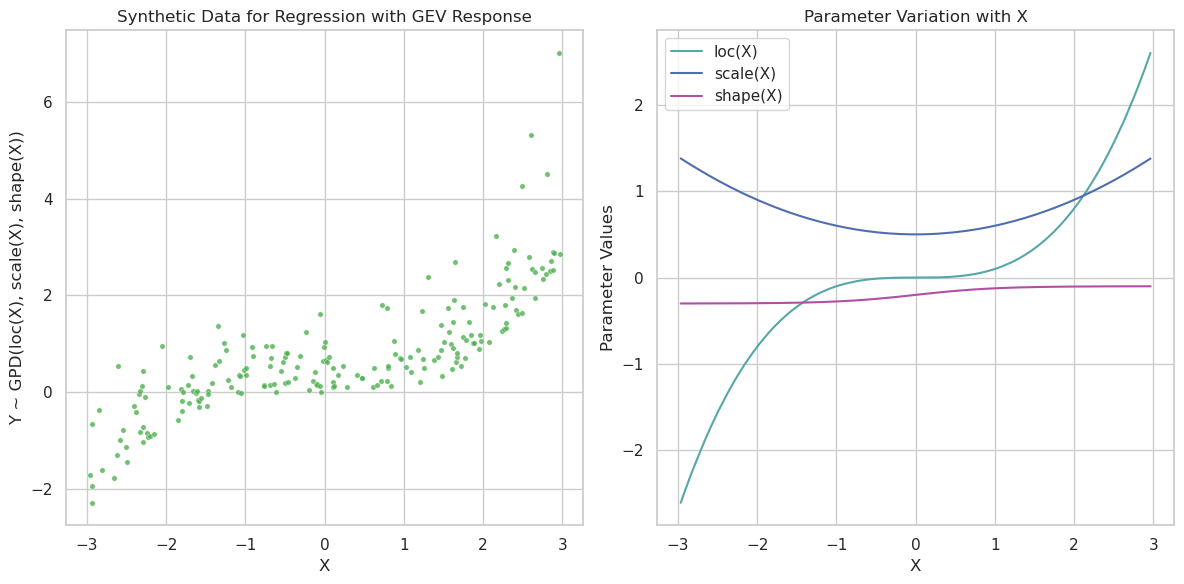

Elapsed time for optimization: 0 min: 29.43 sec


/tmp/ipykernel_466142/1064553110.py:22: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/gpd/syn_data_elbo.svg


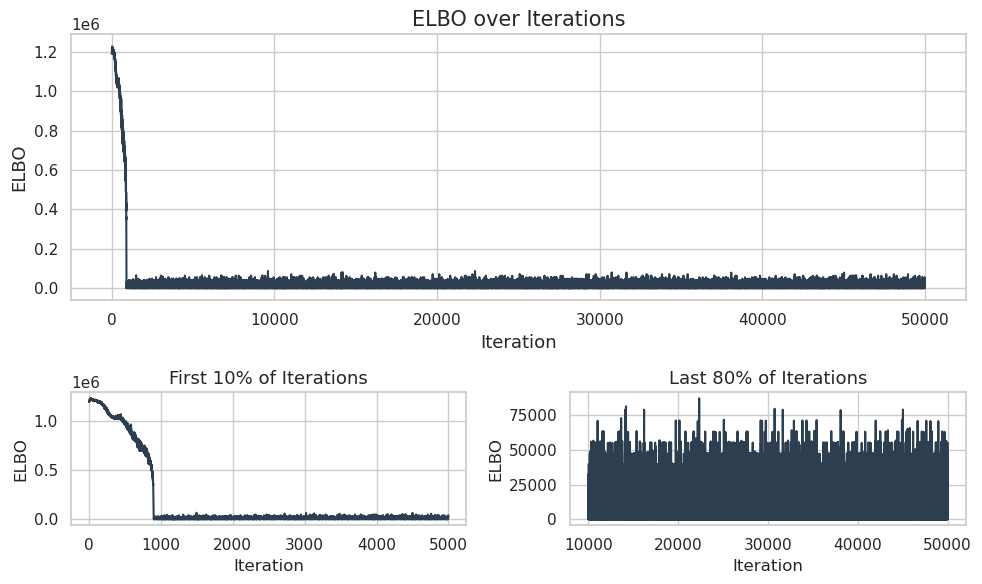

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/gpd/syn_data_regression_results.svg


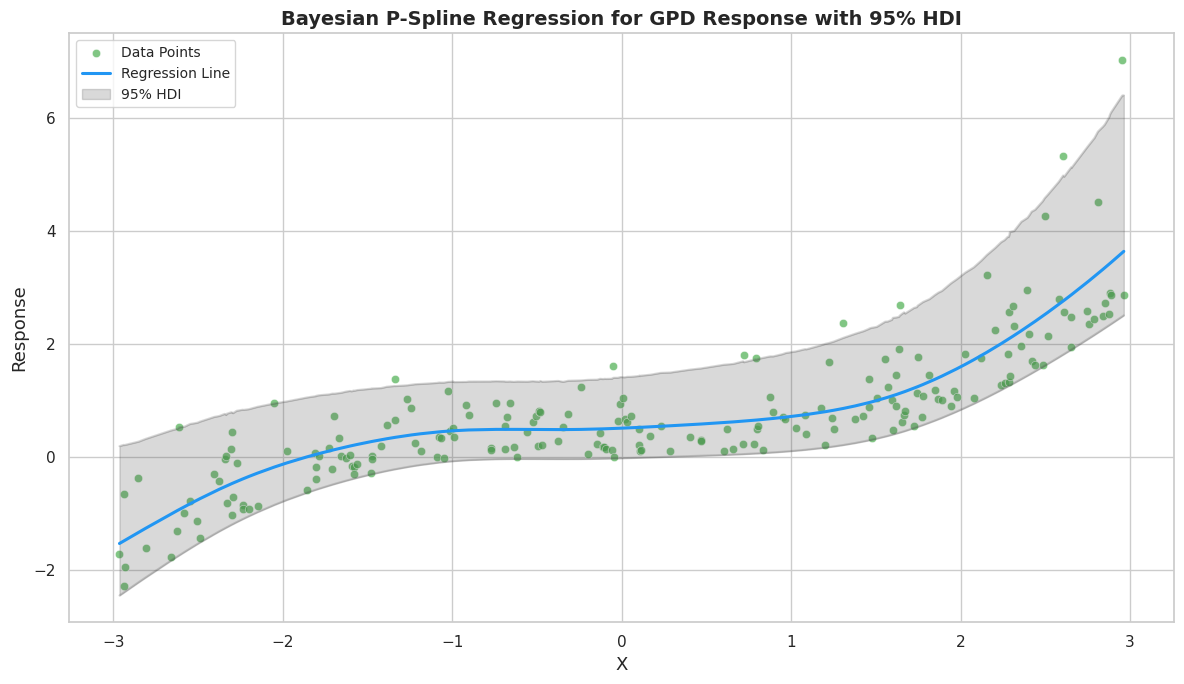

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/gpd/syn_data_true_pred_comp.svg


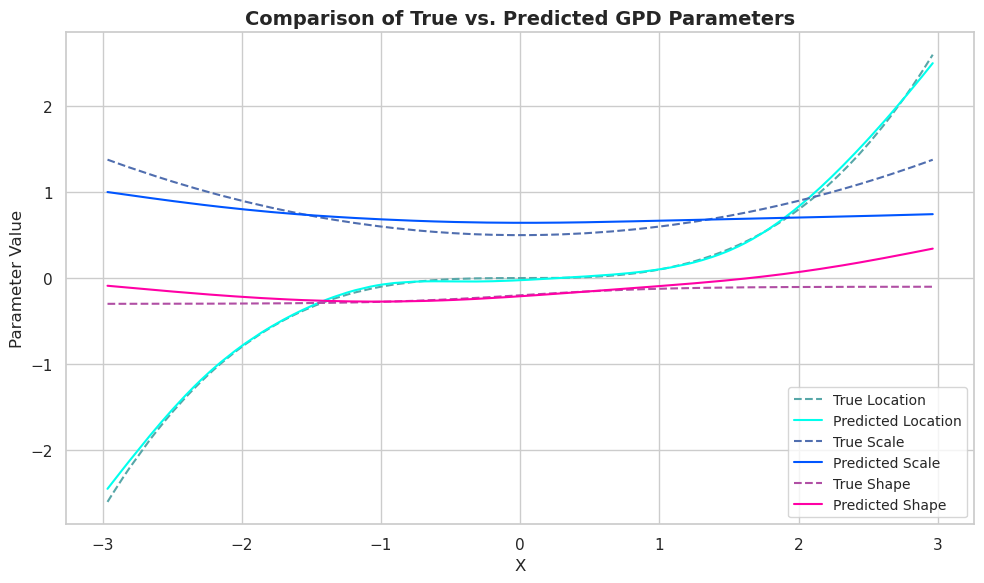

In [8]:
seed = PRNGKey(0)
seed_1, seed_2 = jax.random.split(seed)
X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data(200, seed_1)
DesignMatrix, K = vigamlss_gpd_syn_data_prepare_data(X_SYN)
model = vigamlss_gpd_syn_data_define_model(DesignMatrix, Y_SYN, K)
results = vigamlss_gpd_syn_data_opt_run(model, seed_2)
vigamlss_gpd_syn_data_results(results, DesignMatrix, X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals)
with open(pickle_dir_gpd + f"/results_gpd_50000epochs.pickle", 'wb') as handle:
    pkl.dump(results, handle)

## Simulation

### Conduct SVI Simulation

In [ ]:
num_replications = 100
num_samples = 200
for i in tqdm(range(num_replications)):
    break  # because we already gathered everything
    seed = PRNGKey(i)
    seed_1, seed_2 = jax.random.split(seed)
    X_SYN_SIM, Y_SYN_SIM, loc_vals_SIM, scale_vals_SIM, shape_vals_SIM = vigamlss_gpd_create_syn_data(num_samples, seed_1, enable_plot=False)
    DesignMatrix, K = vigamlss_gpd_syn_data_prepare_data(X_SYN_SIM)
    model = vigamlss_gpd_syn_data_define_model(DesignMatrix, Y_SYN_SIM, K)
    results = vigamlss_gpd_syn_data_opt_run(model, seed_2, print_time=False)
    with open(pickle_dir_gpd_sim + f"/results_gpd_seed_{i}.pickle", 'wb') as handle:
        pkl.dump(results, handle)

100%|██████████| 100/100 [41:12<00:00, 24.73s/it]


### NUTS MCMC

# VIGAMLSS for DBBMI

## Build Bayesian Quantile Regression Model

/tmp/ipykernel_321925/4147801480.py:93: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(linear_predictor_loc_samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/ald/dbbmi_scatterplot.svg
Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/ald/dbbmi_scatterplot.svg


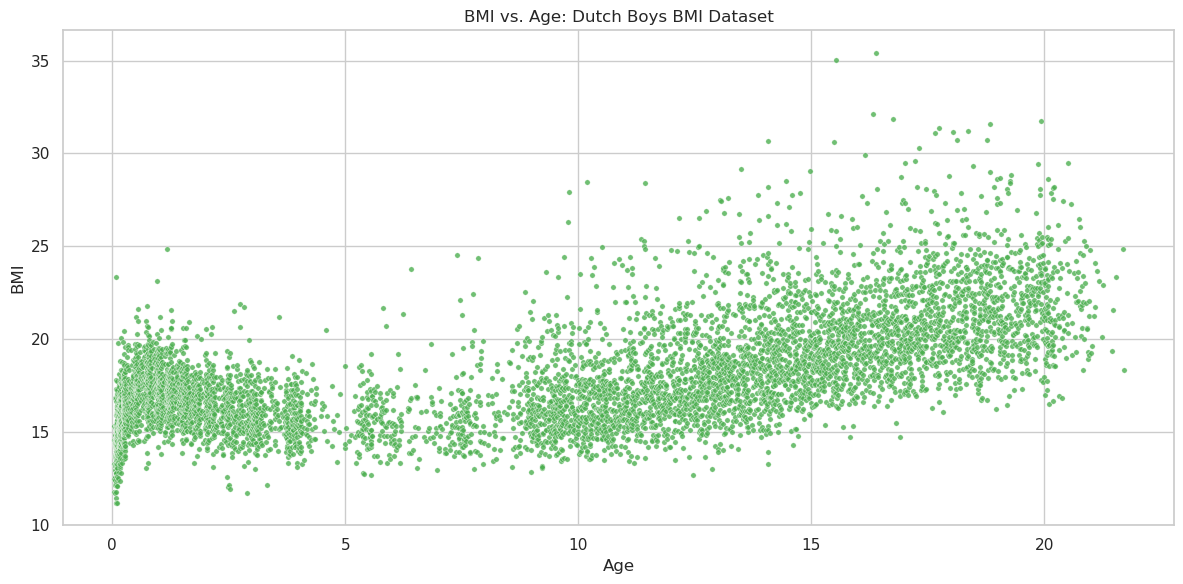

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/ald/dbbmi_qr_elbo.svg


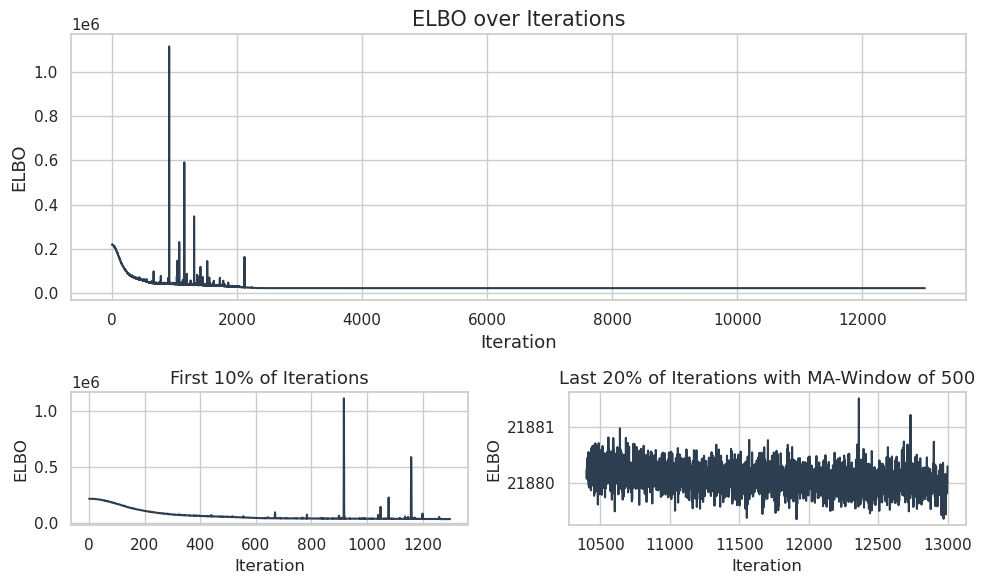

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/ald/dbbmi_qr_regression_results.svg


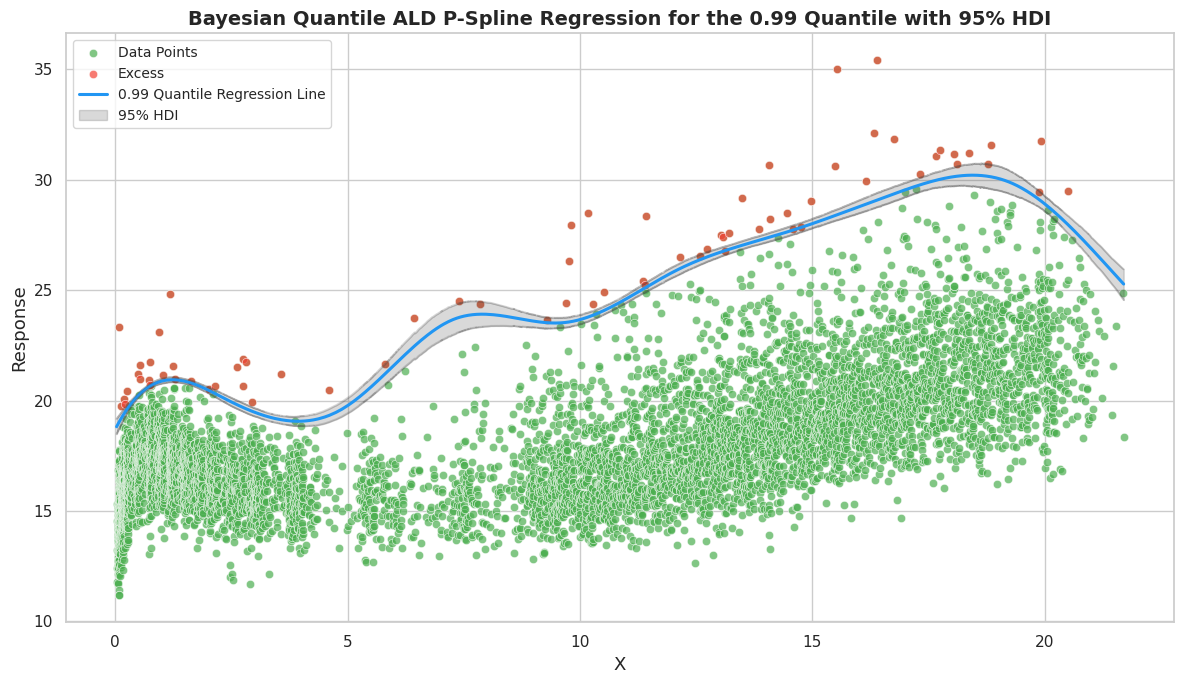

/tmp/ipykernel_321925/4147801480.py:221: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/ald/cgpd_ddbi_elbo.svg


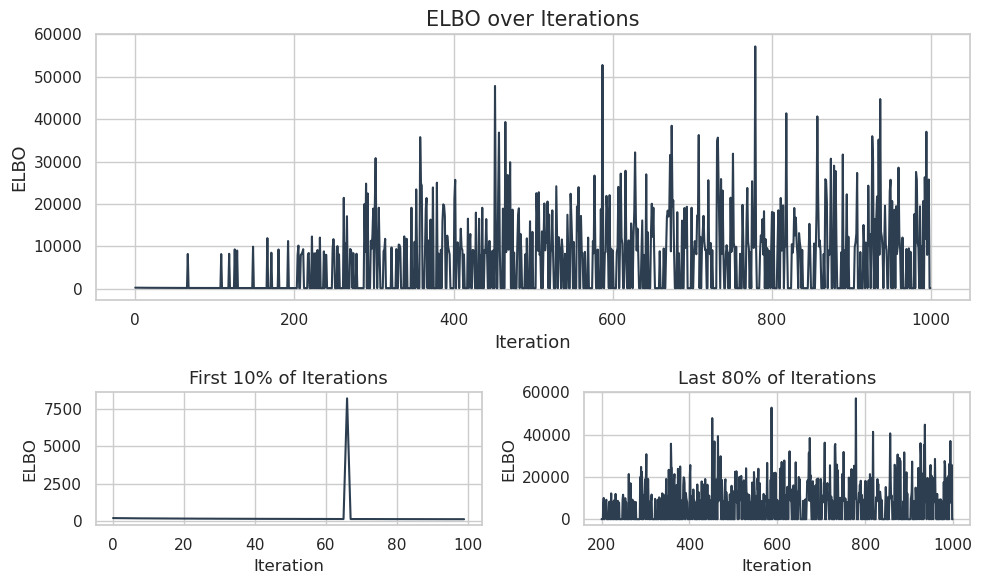

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/ald/cgpd_ddbi_regression_results.svg


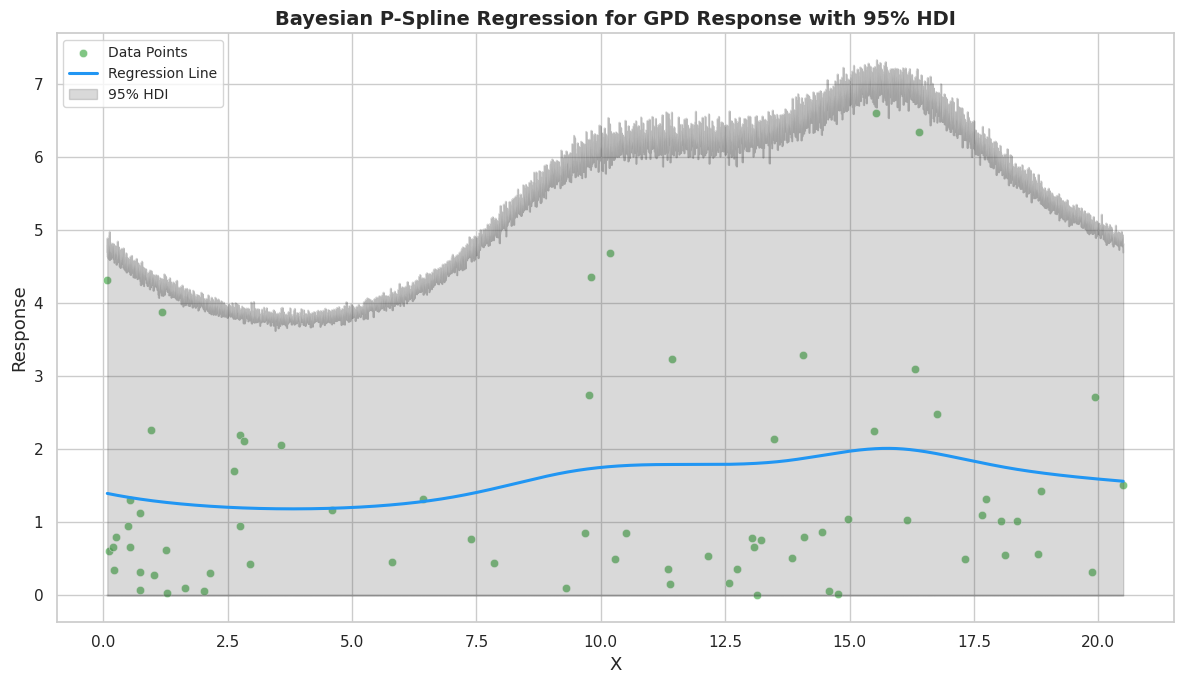

In [10]:
def vigamlss_dbbmi_prepare_qr_data():
    dbbmi_df = pd.read_csv("../data/dbbmi_data.csv")
    Y: np.ndarray = dbbmi_df["bmi"].values
    Y: jnp.ndarray = jnp.array(Y)
    X: np.ndarray = dbbmi_df["age"].values
    X: jnp.ndarray = jnp.array(X)
    DesignMatrix, K = DataPreparator(
        "dbbmi DesignMatrix",
        X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
    )()
    return DesignMatrix, X, Y, K


def vigamlss_ddbmi_qr_define_model(DesignMatrix, Y, K, tau=0.99):
    β0_loc = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_loc = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
    γ_loc = DegenerateNormal("gammas_loc", K, λ_loc)

    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    Y = ALD(
        rv_name="y_GPD",
        loc=β0_loc + DesignMatrix @ γ_loc,
        scale=β0_scale + DesignMatrix @ γ_scale,
        tau=tau,
        responses=Y,
    )
    return Y.model, tau


def vigamlss_ddbmi_qr_opt_run(model, epochs):
    results = model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=epochs,
        mb_size=None,
        lr=0.01,
        max_norm=1.0,
        clip_min_max_enabled=False,
        zero_nans_enabled=False,
        prng_key=PRNGKey(0),
        scheduler_type="warmup_cosine_decay",
        warmup_fraction = 0.01,
        end_value = 1e-4,
        init_value = 1e-5,
        # scheduler_type="warmup_constant",
        # warmup_fraction=0.01,
        # init_value=1e-5,
    )
    return results


def vigamlss_ddbmi_qr_results(results, model, DesignMatrix, X, Y, tau):
    β0_loc_opt = results["transformed_loc_vi_parameters"]["beta0_loc"]
    γ_loc_opt = results["transformed_loc_vi_parameters"]["gammas_loc"]

    linear_predictor_loc = β0_loc_opt + DesignMatrix.matrix @ γ_loc_opt

    split_indices = model.split_indices
    transformations = model.transformations
    rv_names = model.rv_names
    variational_loc = results["loc_vi_parameters_vec"]
    chol_vec = results["chol_vi_vec"]
    variational_lower_triangle = fill_triangular(chol_vec)
    mvn_tril = tfd.MultivariateNormalTriL(variational_loc, variational_lower_triangle)
    with jax.default_device(jax.devices("gpu")[0]):
        loc_vi_parameters_samples = mvn_tril.sample((10000,), PRNGKey(0))
    grouped_loc_vi_parameters_samples = tuple(
        jnp.split(loc_vi_parameters_samples, split_indices, axis=1)
    )
    num_loc_vi_groups = len(grouped_loc_vi_parameters_samples)
    transformed_loc_vi_parameters_samples = jax.tree.map(
        lambda trans, x: trans(x),
        transformations[:num_loc_vi_groups],
        grouped_loc_vi_parameters_samples,
    )
    dict_loc_vi_parameters_samples = dict(
        zip(rv_names[:num_loc_vi_groups], transformed_loc_vi_parameters_samples)
    )
    β0_loc_samples = dict_loc_vi_parameters_samples["beta0_loc"]
    γ_loc_samples = dict_loc_vi_parameters_samples["gammas_loc"]
    linear_predictor_loc_samples = β0_loc_samples + γ_loc_samples @ DesignMatrix.matrix.T
    linear_predictor_loc_samples = np.array(linear_predictor_loc_samples)

    pred_hdi_bounds = az.hdi(linear_predictor_loc_samples, hdi_prob=0.95)
    pred_hdi_lower = pred_hdi_bounds[:, 0]
    pred_hdi_upper = pred_hdi_bounds[:, 1]

    diff = Y - linear_predictor_loc
    excess_mask = diff > 0
    Y_excess = diff[excess_mask]
    X_excess = X[excess_mask]

    plot_data(
        X=X,
        Y=Y,
        scatterplot_color=REGRESSION_COLORPALETTE[0],
        scatter_xlabel="Age",
        scatter_ylabel="BMI",
        scatter_title="BMI vs. Age: Dutch Boys BMI Dataset",
        file_name="dbbmi_scatterplot",
        save_dir=plot_dir_ald,
    )
    plot_elbo(
        num_iterations=results["svi_metadata"]["num_iterations"],
        elbo_values=results["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.1,
        final_percentage=0.2,
        save_dir=plot_dir_ald,
        file_name="dbbmi_qr_elbo",
        apply_ma=(False, False, True),
        window=500,
        tick_label_plain=[False, False, True],
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        x_pred=X,
        pred_mean=linear_predictor_loc,
        lower_hdi_bound=pred_hdi_lower,
        upper_hdi_bound=pred_hdi_upper,
        hdi_alpha=0.2,
        regression_colorpalette=REGRESSION_COLORPALETTE,
        scatter_label="Data Points",
        regression_label=f"{tau} Quantile Regression Line",
        hdi_label="95% HDI",
        xlabel="X",
        ylabel="Response",
        title=f"Bayesian Quantile ALD P-Spline Regression for the {tau} Quantile with 95% HDI",
        save_dir=plot_dir_ald,
        file_name="dbbmi_qr_regression_results",
        excess_mask=excess_mask,
        excess_color=EXCESS_COLOR,
    )
    return Y_excess, X_excess

def vigamlss_dbbmi_prepare_gpd_data(X_excess):
    DesignMatrix, K = DataPreparator(
        "dbbmi DesignMatrix",
        X_excess,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
    )()
    return DesignMatrix, K

def vigamlss_ddbmi_cgpd_define_model(DesignMatrix, Y, K):
    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    β0_shape = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_shape = HalfCauchy("lambda_shape", jnp.array([0.1]), 1)
    γ_shape = DegenerateNormal("gammas_shape", K, λ_shape)

    Y = CenteredGPD(
        "y_GPD",
        β0_scale + DesignMatrix @ γ_scale,
        β0_shape + DesignMatrix @ γ_shape,
        responses=Y,
    )
    return Y.model

def vigamlss_ddbmi_cgpd_opt_run(model, epochs):
    results = model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=epochs,
        mb_size=None,
        lr=0.001,
        max_norm=1.0,
        clip_min_max_enabled=True,
        zero_nans_enabled=True,
        prng_key=PRNGKey(0),
        scheduler_type="constant",
        # warmup_fraction = 0.01,
        # end_value = 1e-4,
        # init_value = 1e-5,
        # scheduler_type="warmup_constant",
        # warmup_fraction=0.01,
        # init_value=1e-5,
    )
    return results

def vigamlss_ddbmi_cgpd_results(results, X, Y):
    β0_scale_opt = results["transformed_loc_vi_parameters"]["beta0_scale"]
    γ_scale_opt = results["transformed_loc_vi_parameters"]["gammas_scale"]
    β0_shape_opt = results["transformed_loc_vi_parameters"]["beta0_shape"]
    γ_shape_opt = results["transformed_loc_vi_parameters"]["gammas_shape"]

    X_min, X_max = X.min(), X.max()
    X_pred = np.linspace(X_min, X_max, 10000)
    pred_DesignMatrix, _ = DataPreparator(
        "xDesign", X_pred, "pspline", intercept=False, standardize=False, degree=3, num_knots=10
    )()

    linear_predictor_scale = TransformationFunctions.softplus(β0_scale_opt + pred_DesignMatrix.matrix @ γ_scale_opt)
    linear_predictor_shape = β0_shape_opt + pred_DesignMatrix.matrix @ γ_shape_opt

    gpd_dists = tfd.GeneralizedPareto(
        jnp.zeros((len(linear_predictor_scale),)), 
        linear_predictor_scale, 
        linear_predictor_shape
    )
    samples = gpd_dists.sample((20000,), PRNGKey(0))
    samples = np.array(samples)

    pred_mean_line = gpd_dists.mean()
    pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)
    pred_hdi_lower = pred_hdi_bounds[:, 0]
    pred_hdi_upper = pred_hdi_bounds[:, 1]

    plot_elbo(
        num_iterations=results["svi_metadata"]["num_iterations"],
        elbo_values=results["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.1,
        final_percentage=0.8,
        save_dir=plot_dir_ald,
        file_name="cgpd_ddbi_elbo",
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        x_pred=X_pred,
        pred_mean=pred_mean_line,
        lower_hdi_bound=pred_hdi_lower,
        upper_hdi_bound=pred_hdi_upper,
        hdi_alpha=0.2,
        regression_colorpalette=REGRESSION_COLORPALETTE,
        scatter_label="Data Points",
        regression_label="Regression Line",
        hdi_label="95% HDI",
        xlabel="X",
        ylabel="Response",
        title="Bayesian P-Spline Regression for GPD Response with 95% HDI",
        save_dir=plot_dir_ald,
        file_name="cgpd_ddbi_regression_results"
    )

epochsQR = 13000
epochsGPD = 1000

DesignMatrixQR, X, Y, K_QR = vigamlss_dbbmi_prepare_qr_data()
modelQR, tau = vigamlss_ddbmi_qr_define_model(DesignMatrixQR, Y, K_QR)
resultsQR = vigamlss_ddbmi_qr_opt_run(modelQR, epochsQR)
with open(pickle_dir_ald + f"/results_dbbmi_qr_{epochsQR}epochs.pickle", "wb") as handle:
    pkl.dump(resultsQR, handle)
# with open (pickle_dir_ald + f"/results_dbbmi_qr_{epochsQR}epochs.pickle", 'rb') as handle:
#    resultsQR = pkl.load(handle)
Y_excess, X_excess = vigamlss_ddbmi_qr_results(resultsQR, modelQR, DesignMatrixQR, X, Y, tau)


DesignMatrixCGPD, K_excess = vigamlss_dbbmi_prepare_gpd_data(X_excess)
modelCGPD = vigamlss_ddbmi_cgpd_define_model(DesignMatrixCGPD, Y_excess, K_excess)
resultsCGPD = vigamlss_ddbmi_cgpd_opt_run(modelCGPD, epochsGPD)
with open(pickle_dir_ald + f"/results_dbbmi_cgpd_{epochsQR}epochs.pickle", "wb") as handle:
    pkl.dump(resultsCGPD, handle)
# with open (pickle_dir_ald + f"/results_dbbmi_cgpd_{epochsQR}epochs.pickle", 'rb') as handle:
#    resultsCGPD = pkl.load(handle)
vigamlss_ddbmi_cgpd_results(resultsCGPD, X_excess, Y_excess)